In [ ]:
# Training of a sequential neural network for soil moisture prediction


# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
root_path ='gdrive/My Drive/soil moisture'


In [ ]:
# BEGIN IMPORTS #
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD

from sklearn import preprocessing

from matplotlib import pyplot
import datetime

import numpy as np
import scipy
import pandas as pd
# END IMPORTS #

In [ ]:
dataset = "gdrive/My Drive/soil.txt"
file1 = open(dataset, "r")


In [ ]:
file1.name

'gdrive/My Drive/soil.txt'

In [ ]:
file1.mode

'r'

In [ ]:
file1.close()

In [ ]:
df = pd.read_csv(dataset)
df


,SAR VH backscatter in dB,SAR VV backscatter in dB,incidence angle in degrees,volumetric soil moisture content
0,-111.440881,-36.467285,30.000000,0.0100
1,-87.612931,-23.666936,30.000000,0.0350
2,-81.519782,-20.147727,30.000000,0.0600
3,-78.338168,-18.243952,30.000000,0.0850
4,-76.294484,-16.992628,30.000000,0.1100
...,...,...,...,...
263,-39.997250,0.945260,32.000000,0.8100
264,-16.550358,-7.048486,30.300486,0.0848
265,-19.314853,-13.688190,30.314545,0.1534
266,-16.578978,-13.389807,30.336458,0.1139


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SAR VH backscatter in dB          268 non-null    float64
 1   SAR VV backscatter in dB          268 non-null    float64
 2   incidence angle in degrees        268 non-null    float64
 3   volumetric soil moisture content  268 non-null    float64
dtypes: float64(4)
memory usage: 8.5 KB


In [ ]:
x = df.drop('volumetric soil moisture content', axis=1)
y = df['volumetric soil moisture content'].copy()

Normalization

In [ ]:
preprocessed_X = preprocessing.minmax_scale(x, feature_range=(0, 1))
preprocessed_X

array([[0.00255986, 0.00343881, 0.        ],
       [0.25302696, 0.34440281, 0.        ],
       [0.31707499, 0.4381443 , 0.        ],
       [0.35051847, 0.48885532, 0.        ],
       [0.37200062, 0.52218692, 0.        ],
       [0.38734481, 0.54639416, 0.        ],
       [0.39904709, 0.56509381, 0.        ],
       [0.40838089, 0.58016293, 0.        ],
       [0.41607337, 0.59268851, 0.        ],
       [0.42257423, 0.60335062, 0.        ],
       [0.42817866, 0.61260018, 0.        ],
       [0.43308967, 0.62074996, 0.        ],
       [0.43745216, 0.62802496, 0.        ],
       [0.44137278, 0.63459193, 0.        ],
       [0.44493208, 0.64057758, 0.        ],
       [0.44819218, 0.64608021, 0.        ],
       [0.45120187, 0.6511774 , 0.        ],
       [0.45399992, 0.65593113, 0.        ],
       [0.45661742, 0.66039124, 0.        ],
       [0.45907924, 0.66459774, 0.        ],
       [0.46140493, 0.66858207, 0.        ],
       [0.46360917, 0.67236773, 0.        ],
       [0.

Split input data into training and test data


In [ ]:
iem_samples = df.shape[0]-4
iem_samples

264

With the variable defined in the previous step, you can split the normalised input (X) and output (y) data into training and test samples. You want to use the first 264( IEM_B )samples for training and the four samples ( Sentinel-1)  as test data.

In [ ]:
test_X_S1 = preprocessed_X[iem_samples:]
preprocessed_X_iem = preprocessed_X[:iem_samples]

test_y_S1 = y[iem_samples:]
y_iem = y[:iem_samples]
test_y_S1

264    0.0848
265    0.1534
266    0.1139
267    0.1060
Name: volumetric soil moisture content, dtype: float64

In a next step, you want to random shuffle the data.



In [ ]:
s = np.arange(iem_samples)
np.random.shuffle(s)
preprocessed_X_shuffled = preprocessed_X_iem[s]
y_shuffled = y_iem[s]

Split training data into training and test data
The next step splits the training data into two subsets:

train_X / train_y --> 70% of the training data
test_X / test_y --> 30% of the training data.
The first 185 entries (70% of 264) are used for training the model and the remaining data are used for testing. You generate training and testing subsets originating from preprocessed_X_shuffled (input) and y_shuffled (output) data.

In [ ]:
n_train_perc = 0.7
n_train = round(preprocessed_X_shuffled.shape[0] * n_train_perc)
n_train

185

In [ ]:
train_X  = preprocessed_X_shuffled[:n_train, :]
train_y  = y_shuffled[:n_train]

test_X = preprocessed_X_shuffled[n_train:, :]
test_y = y_shuffled[n_train:]

n_train, train_X, test_X

(185,
 array([[0.70180495, 0.91197879, 0.18913674],
        [0.61900682, 0.82834089, 0.        ],
        [0.6241224 , 0.84215387, 0.18913674],
        [0.57877274, 0.76557537, 0.18913674],
        [0.46094711, 0.67196671, 0.18913674],
        [0.6108998 , 0.81940157, 0.18913674],
        [0.71280907, 0.93512953, 0.        ],
        [0.72271655, 0.94303856, 0.        ],
        [0.46956481, 0.68264233, 0.        ],
        [0.31443038, 0.43562317, 0.18913674],
        [0.61319919, 0.81851774, 0.        ],
        [0.73025658, 0.95962572, 0.18913674],
        [0.60245933, 0.80051873, 0.        ],
        [0.71117685, 0.9381837 , 0.18913674],
        [0.70490779, 0.92719764, 0.18913674],
        [0.70268509, 0.91767961, 0.        ],
        [0.6340561 , 0.85948845, 0.18913674],
        [0.38466684, 0.54455558, 0.18913674],
        [0.6264117 , 0.84095933, 0.        ],
        [0.73592897, 0.96524908, 0.        ],
        [0.34785618, 0.48660543, 0.18913674],
        [0.60898541, 0.76544

In [ ]:
test_X,test_y

(array([[0.71197676, 0.92525441, 0.        ],
        [0.62179464, 0.83812209, 0.18913674],
        [0.27708345, 0.31164312, 0.        ],
        [0.70831124, 0.92735037, 0.        ],
        [0.63720071, 0.86501993, 0.18913674],
        [0.47981326, 0.61070282, 0.18913674],
        [0.63977217, 0.86955914, 0.18913674],
        [0.62408605, 0.83698484, 0.        ],
        [0.63633462, 0.85803637, 0.        ],
        [0.7134603 , 0.94220764, 0.18913674],
        [0.58758159, 0.7759317 , 0.        ],
        [0.47904672, 0.6991409 , 0.        ],
        [0.71401965, 0.93723061, 0.        ],
        [0.70761436, 0.91809744, 0.        ],
        [0.6896988 , 0.89222693, 0.18913674],
        [0.75156021, 0.9920191 , 0.        ],
        [0.        , 0.        , 0.18913674],
        [0.72572616, 0.9480651 , 0.        ],
        [0.71500288, 0.93385958, 0.18913674],
        [0.64178519, 0.87312261, 0.18913674],
        [0.62432948, 0.78934424, 0.        ],
        [0.66097566, 0.84648802, 0

 Define and compile a sequential neural network model with Keras

In [ ]:
model = keras.Sequential()

In [ ]:
# Layer 1
model.add(Dense(8, input_dim=3))
model.add(LeakyReLU(alpha=0.1))

# Layer 2
model.add(Dense(3))
model.add(LeakyReLU(alpha=0.1))

# Layer 3
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='mean_absolute_error',
              optimizer=SGD(lr=0.01, momentum=0.9),
              metrics=['mse'])

In [ ]:
log_dir = "../../../../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [ ]:
mc = keras.callbacks.ModelCheckpoint('gdrive/My Drive/soil moisture/best_model.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_X, train_y,
                    validation_data=(test_X, test_y),
                    epochs=100,
                    batch_size=10,
                    callbacks=[tensorboard_callback, es, mc])
history

Epoch 1/100
 1/19 [>.............................] - ETA: 6s - loss: 0.1816 - mse: 0.0458
Epoch 1: val_mse improved from 0.14900 to 0.04562, saving model to gdrive/My Drive/soil moisture/best_model.h5
19/19 [==============================] - 1s 23ms/step - loss: 0.1690 - mse: 0.0400 - val_loss: 0.1833 - val_mse: 0.0456
Epoch 2/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2127 - mse: 0.0503
Epoch 2: val_mse improved from 0.04562 to 0.04486, saving model to gdrive/My Drive/soil moisture/best_model.h5
19/19 [==============================] - 0s 11ms/step - loss: 0.1704 - mse: 0.0397 - val_loss: 0.1810 - val_mse: 0.0449
Epoch 3/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1913 - mse: 0.0425
Epoch 3: val_mse did not improve from 0.04486
19/19 [==============================] - 0s 9ms/step - loss: 0.1685 - mse: 0.0396 - val_loss: 0.1820 - val_mse: 0.0453
Epoch 4/100
18/19 [===========================>..] - ETA: 0s - loss: 0.1687 - mse: 0.0393
Epoch 4: val_

In [ ]:
model = keras.models.load_model('gdrive/My Drive/best_model1.h5')
model

In [ ]:
_, test_mse = model.evaluate(test_X, test_y)

print('Mse: %.4f' % test_mse)


3/3 [==============================] - 0s 4ms/step - loss: 0.1818 - mse: 0.0450
Mse: 0.0450


Another useful evaluation is to plot the loss and validation_loss metrics during training.
loss: mean absolute error during training (blue line)
validation_loss: mean absolute error while validating the training outputs with test data (orange line)


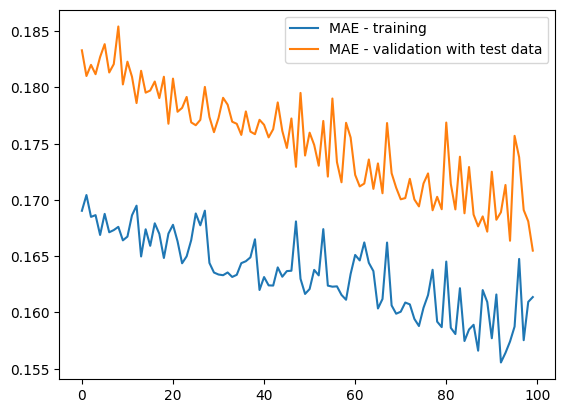

In [ ]:
pyplot.plot(history.history['loss'], label='MAE - training')
pyplot.plot(history.history['val_loss'], label='MAE - validation with test data')
pyplot.legend()

 Predicting soil moisture with the trained sequential neural network


In [ ]:
predicted = []
for index, value in enumerate(test_X_S1):
    pred = np.expand_dims(value, axis=0)
    predicted.append(model.predict(pred))

    print("Input values: " + str(value) + ",  Output soil moisture: ") #+ str(test_y_S1[index]))
    print("Predicted soil moisture: " + str(model.predict(pred)) + "\n ")



1/1 [==============================] - 0s 64ms/step
Input values: [1.         0.78706989 0.02841644],  Output soil moisture: 
1/1 [==============================] - 0s 21ms/step
Predicted soil moisture: [[0.48461]]
 
1/1 [==============================] - 0s 21ms/step
Input values: [0.97094106 0.61020754 0.02974598],  Output soil moisture: 
1/1 [==============================] - 0s 27ms/step
Predicted soil moisture: [[0.3681441]]
 
1/1 [==============================] - 0s 27ms/step
Input values: [0.99969916 0.61815558 0.0318183 ],  Output soil moisture: 
1/1 [==============================] - 0s 28ms/step
Predicted soil moisture: [[0.3776444]]
 
1/1 [==============================] - 0s 24ms/step
Input values: [0.96187422 0.65006854 1.        ],  Output soil moisture: 
1/1 [==============================] - 0s 25ms/step
Predicted soil moisture: [[0.308207]]
 


Text(0, 0.5, 'Predicted')

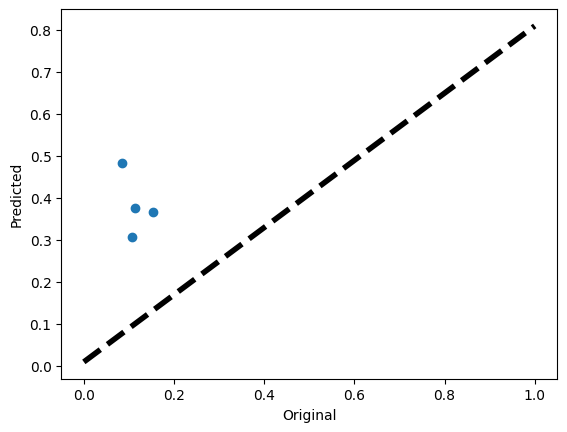

In [ ]:
fig, ax = pyplot.subplots()
ax.scatter(test_y_S1, predicted)
ax.plot([test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')

As a final step, you can calculate the Pearson correlation coefficient between original (to-predict) and predicted soil moisture values. The coefficient value can range between [-1,1] and is a measure about the strength of the correlation between original and predicted soil moisture.

In [ ]:
 test_y_nparray = np.array(test_y_S1)
test_y_flattened = test_y_nparray.flatten()
predicted_nparray = np.array(predicted)
predicted_flattened = predicted_nparray.flatten()

corr, _ = scipy.stats.pearsonr(test_y_flattened, predicted_flattened)
print('Pearson correlation: %.3f' % corr)

Pearson correlation: -0.468
